In [30]:
import os
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, Resize, Lambda, Normalize
from torch.utils.data import DataLoader, Subset
from monai.networks.nets import UNet

%autoreload 2
from networks import *
from utils import set_device, set_seed
from losses import AWLoss
from datasets import MaskedUltrasoundDataset2D


import matplotlib.pyplot as plt
import progressbar
import random
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CUDA Setup

In [31]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)                     
device=set_device("cuda", 0)              

Cuda installed! Running on GPU 0 NVIDIA A100-SXM4-80GB!


# MRI Dataset 

In [32]:
def scale2range(x, range=[-1, 1]):
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

def clip_outliers(x, fence="outer"):
    f = 1.5 if fence=="inner" else 3.0
    q1 = torch.quantile(x, q=0.25)
    q3 = torch.quantile(x, q=0.75)
    iqr = q3 - q1
    lower = q1 - f*iqr
    upper = q3 + f*iqr
    x[torch.where(x < lower)] = lower
    x[torch.where(x > upper)] = upper
    return x

def create_mask(size, width):
    assert len(size) == len(width)
    m = torch.zeros(size)
    idxs = []
    for i in range(len(size)):
        dx = width[i]
        idx = [j*dx for j in range(int(size[i]/dx) +1)]
        idx = idx[:-1] if idx[-1] == size[i] else idx
        idxs.append(torch.tensor(idx))
    idmesh = torch.meshgrid(*idxs)
    
    m[idmesh] = 1.
    return m

In [33]:
# path = os.path.abspath("/media/dekape/HDD/Ultrasound-MRI-sagittal/")
path = os.path.abspath("/home/dp4018/data/ultrasound-data/Ultrasound-MRI-sagittal/")
train_transform = Compose([
                    Resize(256),
                    Lambda(lambda x: x / x.abs().max()),
                    Lambda(lambda x: clip_outliers(x)),
                    Lambda(lambda x: scale2range(x, [-1., 1.])),
                    # Normalize([0.09779735654592514], [0.16085614264011383])
                    ])

mask = create_mask((256,256), (1,3))

ds = MaskedUltrasoundDataset2D(path, 
                                    mode="mri",
                                    transform=train_transform,
                                    mask=mask,
                                    maxsamples=None)
print(ds, "\n")
print(ds.info())

{'name': 'MaskedUltrasoundDataset2D', 'path': '/home/dp4018/data/ultrasound-data/Ultrasound-MRI-sagittal', 'maxsamples': None, 'transform': Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    Lambda()
    Lambda()
    Lambda()
), 'mask': tensor([[1., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 1.]]), 'mode': 'mri', 'len': 553} 

{'max': 1.0, 'min': -1.0, 'mean': -0.21459859609603882, 'std': 0.35723158717155457, 'shape': torch.Size([1, 256, 256])}


## Data split

In [34]:
valid_ratio = 0.3
i = int(len(ds)*valid_ratio)

idxs = np.arange(0, len(ds), 1)
np.random.shuffle(idxs)

train_idxs, valid_idxs = idxs[:-i], idxs[-i:]
trainds, validds = Subset(ds, train_idxs), Subset(ds, valid_idxs)

print(len(trainds), len(validds))

388 165


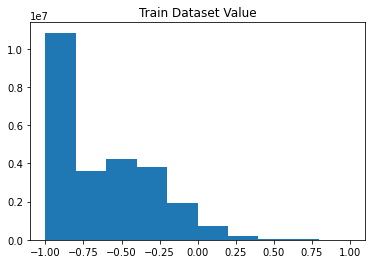

In [35]:
data = []
for i in range(len(trainds)):
    data += list((trainds[i][1].flatten().detach().cpu().numpy()))
plt.title("Train Dataset Value")
plt.hist(data)
plt.show()

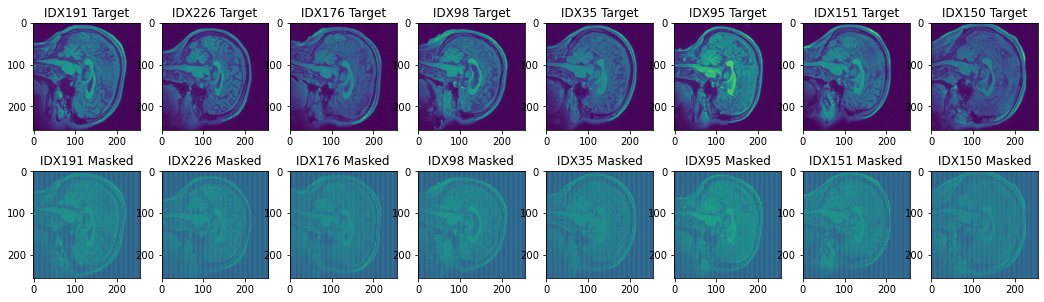

In [36]:
fig, axs = plt.subplots(2,8, figsize=(18, 5))
for i, n in enumerate(np.random.randint(0, len(trainds), size=(axs.shape[1]))):
    tgt = axs[0][i].imshow(trainds[n][1].permute(1,2,0), vmin=-1, vmax=1)
    axs[0][i].set_title("IDX%g Target"%n)
    msk = axs[1][i].imshow(trainds[n][0].permute(1,2,0), vmin=-1, vmax=1)
    axs[1][i].set_title("IDX%g Masked"%n)

# Model 

In [37]:
def make_model(nc=64):
    channels = (16, 32, 64)#, 128, 256)
    model =  UNet(
    spatial_dims=2,
    in_channels=nc,
    out_channels=nc,
    channels=channels,
    strides=tuple([2 for i in range(len(channels))]), 
    num_res_units=1,
    act="mish")
    model = nn.DataParallel(model) 
    return model.to(device)
print(make_model())

DataParallel(
  (module): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (adn): ADN(
              (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (D): Dropout(p=0.0, inplace=False)
              (A): Mish()
            )
          )
        )
        (residual): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
      (1): SkipConnection(
        (submodule): Sequential(
          (0): ResidualUnit(
            (conv): Sequential(
              (unit0): Convolution(
                (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                (adn): ADN(
                  (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
                  (D): Dropout(p=0.0, inplace=False)
   

/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


# Train and Validate Functions

In [38]:
def train(model, train_loader, optimizer, criterion, device="cpu"):
    """ Trains one epoch, validates with MSE """
    model.train()
    
    total_loss = 0.
    total_mse = 0.

    for i , (X, target) in enumerate(train_loader):
        X, target = X.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon = torch.tanh(model(X))

        # Evaluate losses
        loss  = criterion(recon, target)
        mse = nn.MSELoss(reduction="mean")(recon, target)

        # Backprop and optim step
        loss.backward()
        optimizer.step()  
        
        # Keep track of total losses
        total_loss += loss / len(train_loader)
        total_mse += mse / len(train_loader)
    
    return total_loss, total_mse

def validate(model, train_loader, criterion, device="cpu"):
    """ Validates model with criterion and MSE"""
    model.eval()

    total_loss = 0.
    total_mse = 0.

    for i , (X, target) in enumerate(train_loader):
        X, target = X.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon = torch.tanh(model(X))

        # Evaluate losses
        loss  = criterion(recon, target)
        mse = nn.MSELoss(reduction="mean")(recon, target)
        
        # Keep track of total losses
        total_loss += loss / len(train_loader)
        total_mse += mse / len(train_loader)
    
    return total_loss, total_mse

In [39]:
def train_model(model, optimizer, loss, train_loader, valid_loader=None, nepochs=150, log_frequency=10, sample_input=None, sample_target=None, device="cpu"):
    print("\n\nTraining started ...")
    all_train_losses, all_valid_losses, all_train_mse, all_valid_mse = [], [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            # Train epoch
            train_loss, train_mse = train(model, train_loader, optimizer, loss, device)
            valid_loss, valid_mse = validate(model, valid_loader, loss, device)
            
            all_train_losses.append(train_loss.item())
            all_train_mse.append(train_mse.item())
            all_valid_losses.append(valid_loss.item())
            all_valid_mse.append(valid_mse.item())
            bar.update(epoch)
            
            # Logging
            log = {"epoch": epoch, "train_loss": train_loss.item(), "train_mse":train_mse.item(), "valid_loss": valid_loss.item(), "valid_mse":valid_mse.item()}
            if (epoch % log_frequency == 0 or epoch==nepochs-1):
                print("\n", log)

                # Figure for plotting
                fig, axs = plt.subplots(2,3, figsize=(15, 10))
                axs = axs.flatten()

                # Plot losses
                axs[0].plot(all_train_losses, label="train")
                axs[0].plot(all_valid_losses, label="valid")
                axs[0].legend()
                axs[0].set_title(str(loss))
                axs[0].set_xlabel("epoch")

                axs[1].plot(all_train_mse, label="train")
                axs[1].plot(all_valid_mse, label="valid")
                axs[1].legend()
                axs[1].set_xlabel("epoch")
                axs[1].set_title("MSE")

                # Plots
                if sample_input is not None:
                    idx = int(sample_input.shape[0]/2)

                    # Model forward pass
                    model.eval()
                    X = sample_input.unsqueeze(0).to(device)
                    recon = torch.tanh(model(X))[0]

                    # Plot sample input
                    im = axs[3].imshow(sample_input[idx], vmin=-1, vmax=1)
                    fig.colorbar(im, ax=axs[3], shrink=0.5)
                    axs[3].set_title("Input idx %g"%idx)

                    # Plot reconstruction
                    im = axs[4].imshow(recon[idx].cpu().detach().numpy(), vmin=-1, vmax=1)
                    fig.colorbar(im, ax=axs[4], shrink=0.5)
                    axs[4].set_title("Reconstruction idx %g"%idx)

                    
                    if sample_target is not None:
                        # Plot target input
                        im = axs[5].imshow(sample_target[idx], vmin=-1, vmax=1)
                        fig.colorbar(im, ax=axs[5], shrink=0.5)
                        axs[5].set_title("Target idx %g"%idx)

                        # Loss evaluation and filters
                        print(recon.shape, sample_target.shape)
                        f = loss(recon.unsqueeze(0).to(device), sample_target.unsqueeze(0).to(device))
                        if "awloss" in str(loss).lower():
                            try:
                                v, T = loss.filters[0], loss.T
                            except:
                                loss_list = [str(l) for l in loss.losses]
                                awloss = loss.losses[loss_list.index("AWLoss()")]
                                v, T = awloss.filters[0], awloss.T
                            # Plot filter
                            axs[2].plot(v.flatten().cpu().detach().numpy(), label="Wiener Filter")
                            axs[2].set_ylim(None, 1.1)
                            axs[2].legend()
                            print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())
                        else:
                            pass


            plt.show()

# Training Setup

In [40]:
# Set training static parameters and hyperparameters
nepochs=1000                        
learning_rate=1e-2
batch_size=64                                        

# Dataloader
train_loader = DataLoader(trainds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)
valid_loader = DataLoader(validds,
                        batch_size=1000,
                        shuffle=False,
                        num_workers=4)


# Sample for visualisation
x_sample, y_sample = validds[0]

# Joint Loss

In [41]:
from math import log, floor
class JointLoss(nn.Module):
    def __init__(self, losses, weights, norm=False):
        super(JointLoss, self).__init__()
        self.losses = losses
        self.weights = weights
        self.norm = norm

    def __str__(self):
        name = ""
        for l , w in zip(self.losses, self.weights):
            name += "{}(w={:.1E}) ".format(str(l)[:-2], w)
        return name[:-1]

    def scale(self, x):
        if self.norm:
            return x / 10**floor(log(x, 10))
        else:
            return x

    def forward(self, x, y):
        total_loss = 0.
        for l, w in zip(self.losses, self.weights):
            total_loss += w * self.scale(l(x, y))
        return total_loss

# Train MSE Loss



Training started ...


N/A% (0 of 600) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_loss': 0.7430240511894226, 'train_mse': 0.7430240511894226, 'valid_loss': 0.5600921511650085, 'valid_mse': 0.5600921511650085}
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


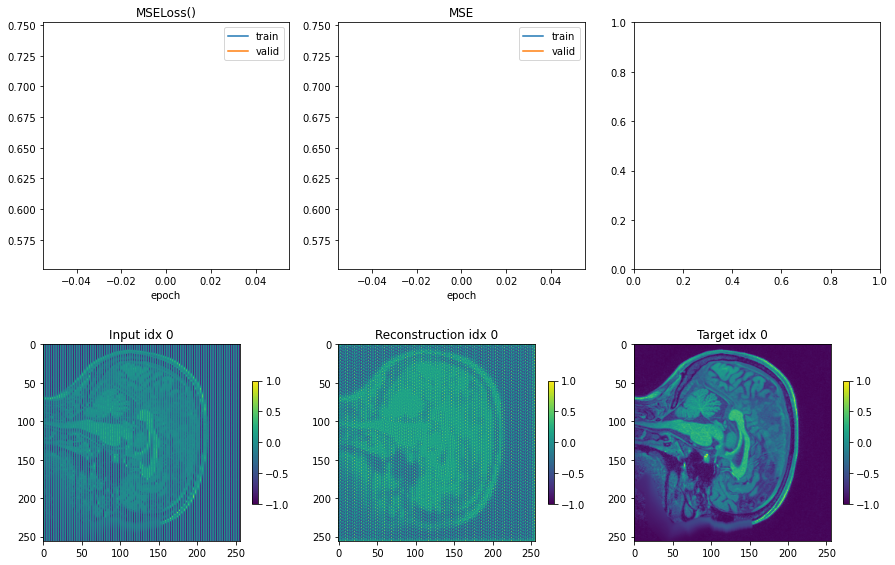

 25% (150 of 600) |#####                 | Elapsed Time: 0:16:20 ETA:   0:48:30


 {'epoch': 150, 'train_loss': 0.004700002260506153, 'train_mse': 0.004700002260506153, 'valid_loss': 0.00444948161020875, 'valid_mse': 0.00444948161020875}
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


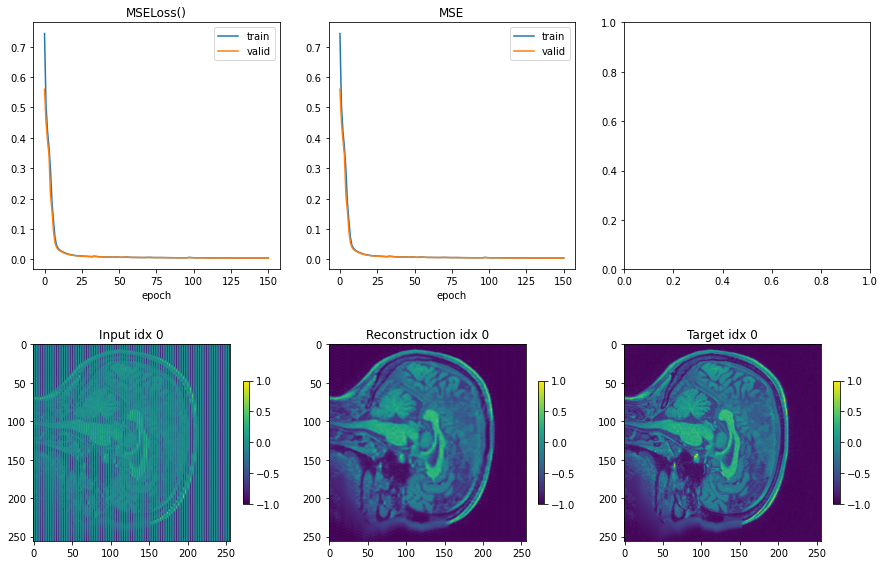

 50% (300 of 600) |###########           | Elapsed Time: 0:32:40 ETA:   0:33:29


 {'epoch': 300, 'train_loss': 0.0036072374787181616, 'train_mse': 0.0036072374787181616, 'valid_loss': 0.0035933132749050856, 'valid_mse': 0.0035933132749050856}
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


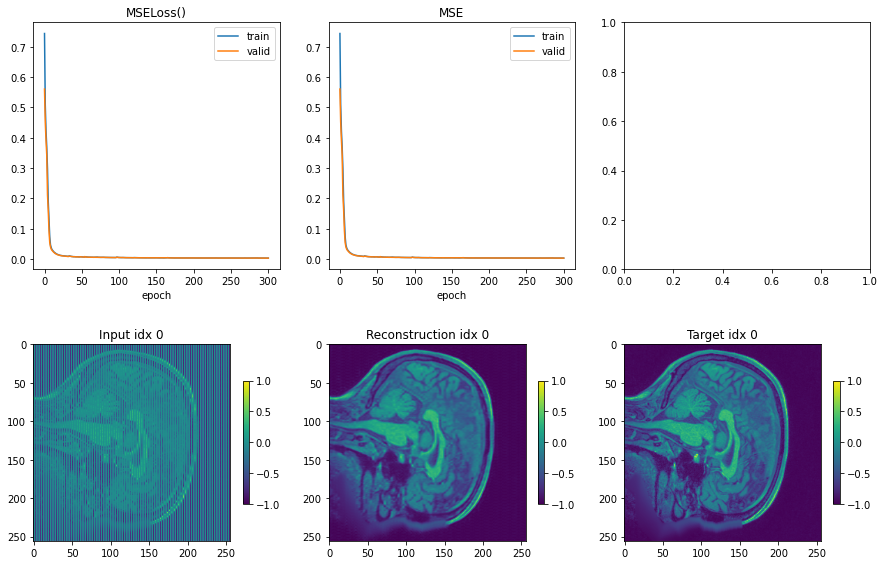

 75% (450 of 600) |################      | Elapsed Time: 0:48:59 ETA:   0:17:22


 {'epoch': 450, 'train_loss': 0.0034309295006096363, 'train_mse': 0.0034309295006096363, 'valid_loss': 0.003337338799610734, 'valid_mse': 0.003337338799610734}
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


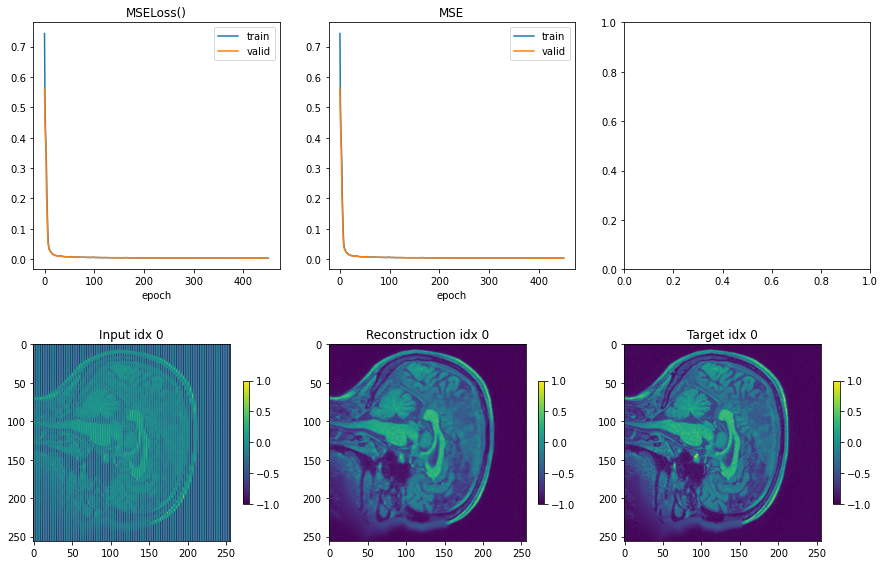

 99% (599 of 600) |##################### | Elapsed Time: 1:05:15 ETA:   0:00:06


 {'epoch': 599, 'train_loss': 0.0032583484426140785, 'train_mse': 0.0032583484426140785, 'valid_loss': 0.0031830095686018467, 'valid_mse': 0.0031830095686018467}
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


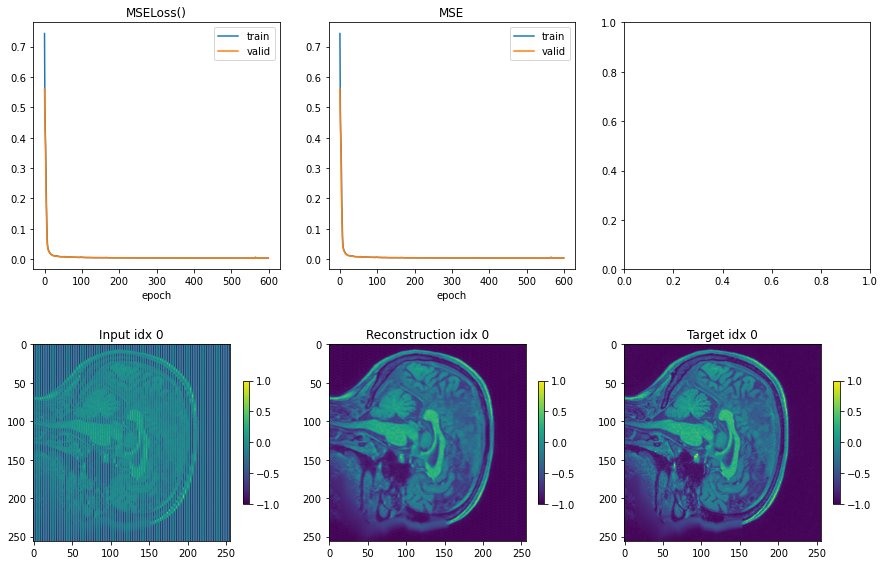

100% (600 of 600) |######################| Elapsed Time: 1:05:16 Time:  1:05:16


In [42]:
model = make_model(nc=x_sample.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

mseloss     = nn.MSELoss(reduction="mean")

train_model(model, optimizer, mseloss, train_loader,  valid_loader=valid_loader, nepochs=600, log_frequency=150, sample_input=x_sample, sample_target=y_sample, device=device)

# Train AWLoss



Training started ...


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_loss': 0.6998461484909058, 'train_mse': 1.336442232131958, 'valid_loss': 0.6939443945884705, 'valid_mse': 1.2808728218078613}
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
 argidx T, v:  130560 130560


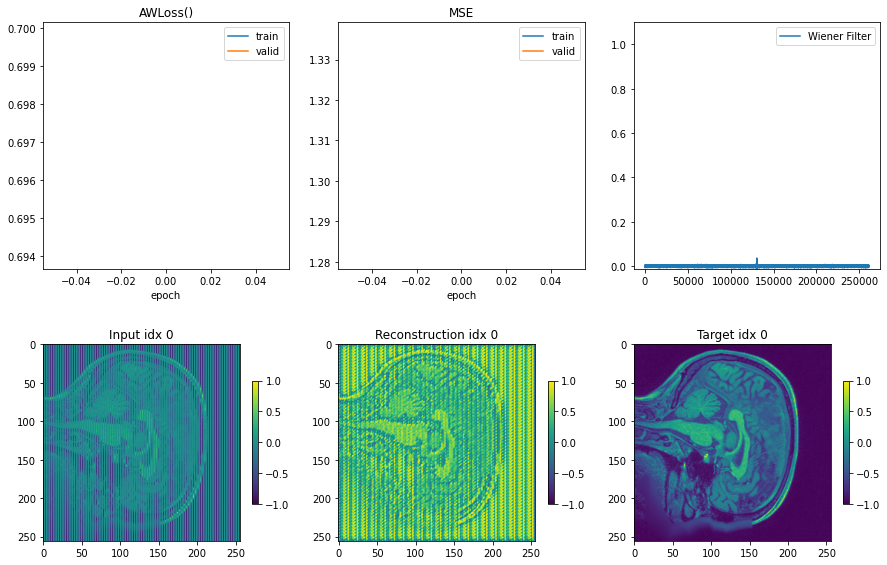

 15% (150 of 1000) |###                  | Elapsed Time: 0:17:54 ETA:   1:40:38


 {'epoch': 150, 'train_loss': 0.5645938515663147, 'train_mse': 0.09010954946279526, 'valid_loss': 0.5777809619903564, 'valid_mse': 0.09517937898635864}
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
 argidx T, v:  130560 130560


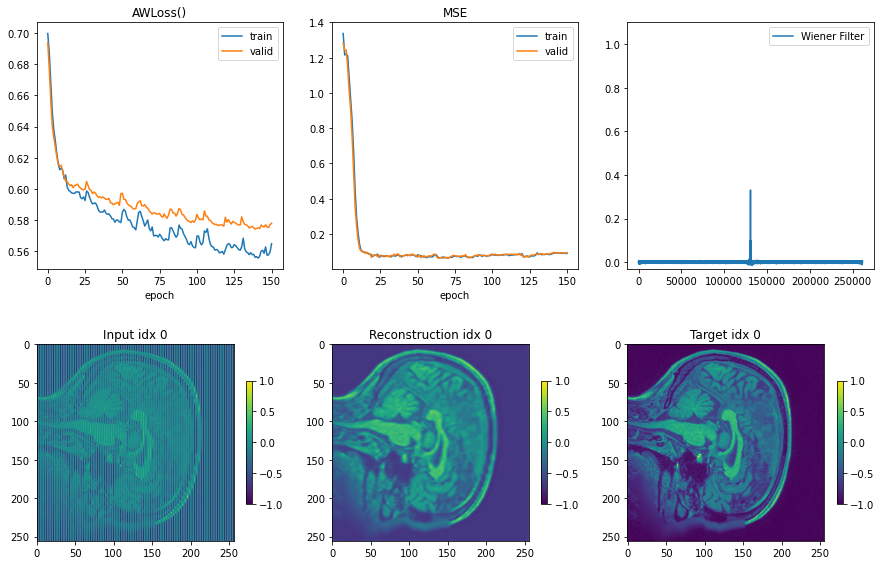

 30% (300 of 1000) |######               | Elapsed Time: 0:35:49 ETA:   1:20:51


 {'epoch': 300, 'train_loss': 0.5474109649658203, 'train_mse': 0.14236590266227722, 'valid_loss': 0.5715386271476746, 'valid_mse': 0.1428440511226654}
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
 argidx T, v:  130560 130560


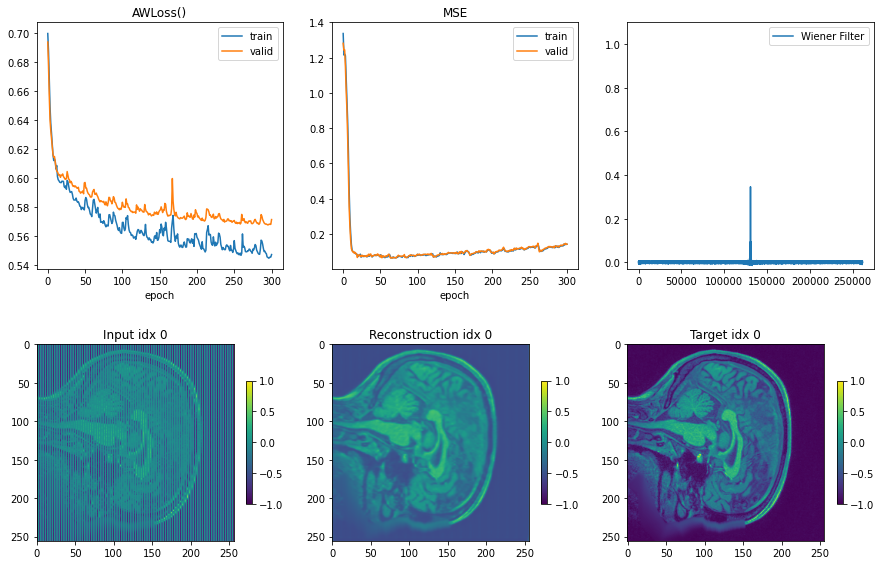

 45% (450 of 1000) |#########            | Elapsed Time: 0:53:45 ETA:   1:08:06


 {'epoch': 450, 'train_loss': 0.5433862209320068, 'train_mse': 0.14687156677246094, 'valid_loss': 0.5661307573318481, 'valid_mse': 0.14847446978092194}
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
 argidx T, v:  130560 130560


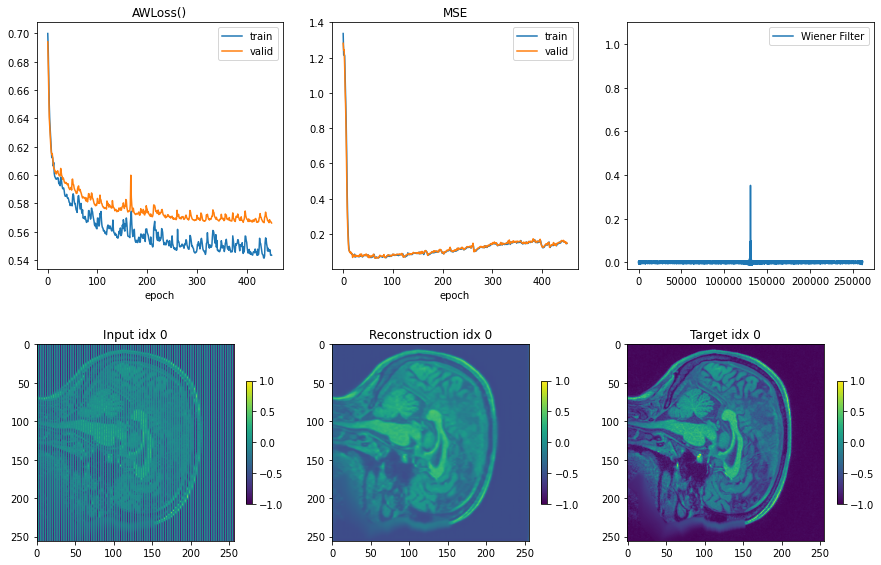

 60% (600 of 1000) |############         | Elapsed Time: 1:11:35 ETA:   0:48:43


 {'epoch': 600, 'train_loss': 0.5416363477706909, 'train_mse': 0.14727169275283813, 'valid_loss': 0.5661295652389526, 'valid_mse': 0.15023745596408844}
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
 argidx T, v:  130560 130560


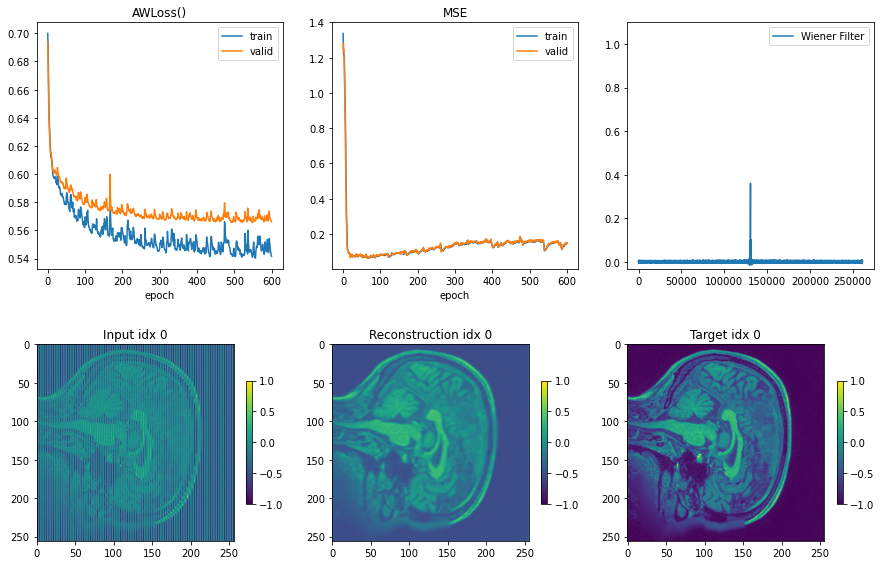

 75% (750 of 1000) |###############      | Elapsed Time: 1:29:33 ETA:   0:29:11


 {'epoch': 750, 'train_loss': 0.5420801639556885, 'train_mse': 0.13169269263744354, 'valid_loss': 0.5655754208564758, 'valid_mse': 0.1362171769142151}
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
 argidx T, v:  130560 130560


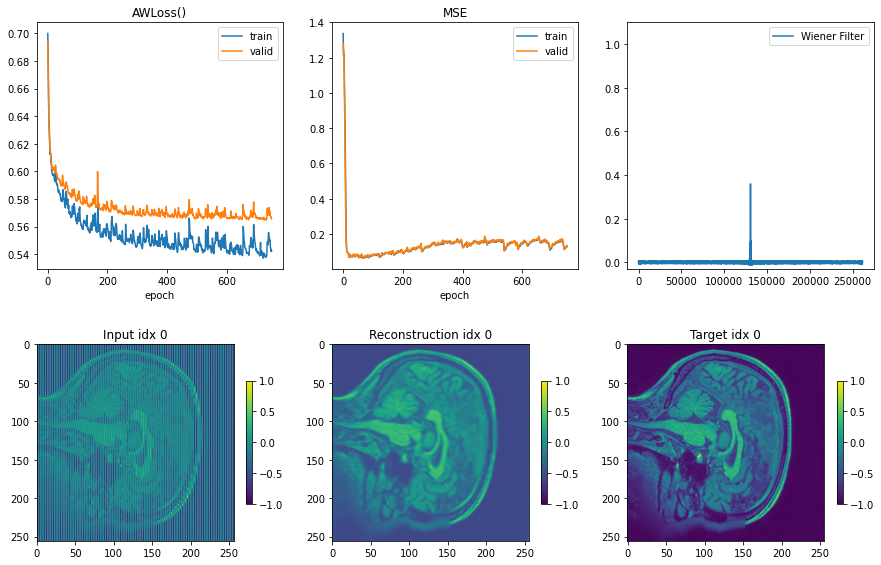

 90% (900 of 1000) |##################   | Elapsed Time: 1:47:32 ETA:   0:11:27


 {'epoch': 900, 'train_loss': 0.5400375127792358, 'train_mse': 0.1578122228384018, 'valid_loss': 0.5650346875190735, 'valid_mse': 0.15502862632274628}
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
 argidx T, v:  130560 130560


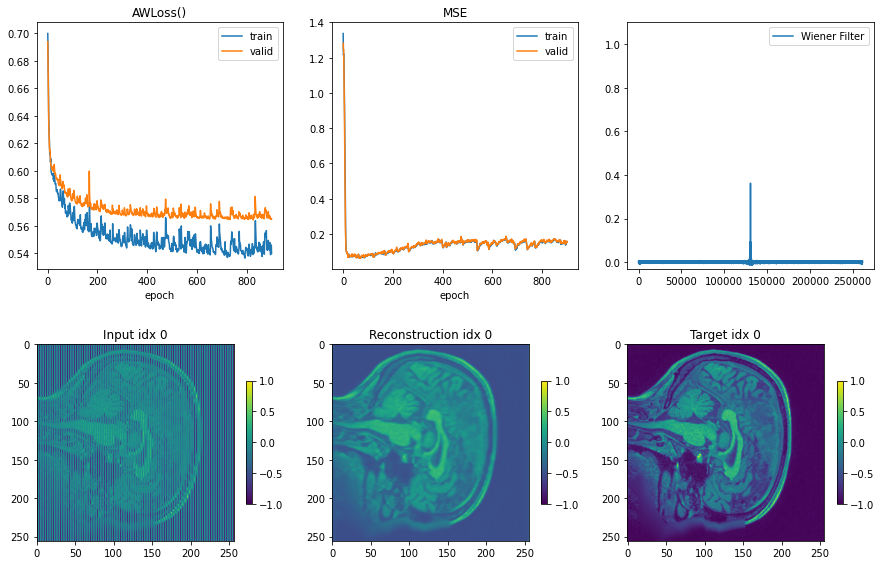

 99% (999 of 1000) |#################### | Elapsed Time: 1:59:04 ETA:   0:00:06


 {'epoch': 999, 'train_loss': 0.5420944094657898, 'train_mse': 0.15086151659488678, 'valid_loss': 0.5663442015647888, 'valid_mse': 0.15880492329597473}
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
 argidx T, v:  130560 130560


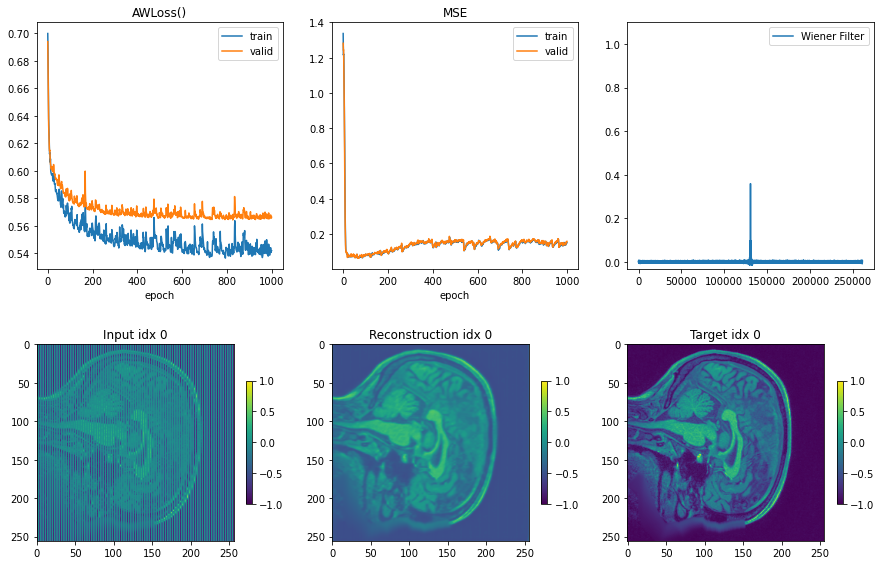

100% (1000 of 1000) |####################| Elapsed Time: 1:59:05 Time:  1:59:05


In [43]:
model = make_model(nc=x_sample.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

awloss     = AWLoss(filter_dim=2, method="fft", reduction="mean", std=3e-4, store_filters="norm", epsilon=3e-15)

train_model(model, optimizer, awloss, train_loader, valid_loader=valid_loader, nepochs=nepochs, log_frequency=150, sample_input=x_sample, sample_target=y_sample, device=device)

# Train AWLoss + MSE



Training started ...


/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_loss': 1.0496762990951538, 'train_mse': 0.6849793791770935, 'valid_loss': 0.9362820386886597, 'valid_mse': 0.45910531282424927}
torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
 argidx T, v:  130560 191868


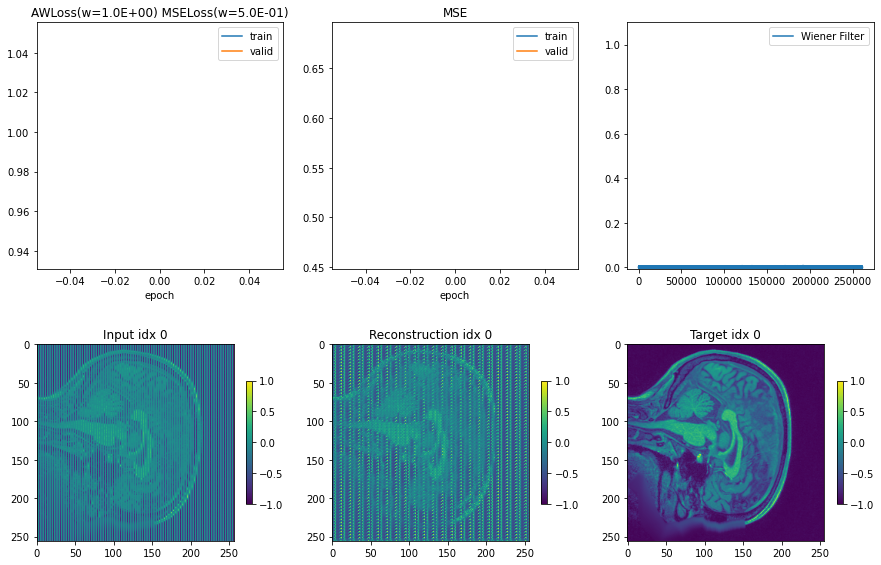

100% (1000 of 1000) |####################| Elapsed Time: 0:01:50 Time:  0:01:50


KeyboardInterrupt: 

In [44]:
model = make_model(nc=x_sample.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

awloss      = AWLoss(filter_dim=2, method="fft", reduction="mean", std=3e-4, store_filters="norm", epsilon=3e-15)
mseloss     = nn.MSELoss(reduction="mean")
combined    = JointLoss((awloss, mseloss), (1., 0.5))

train_model(model, optimizer, combined, train_loader, valid_loader=valid_loader, nepochs=nepochs, log_frequency=150, sample_input=x_sample, sample_target=y_sample, device=device)